# Project Statement

## Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log
returns of a stock/index are normally distributed.

Investigate if the log returns of stocks or indexes of your choosing are
normally distributed. Some suggestions for exploration include:

1.  Test if there are period of times when the log-returns of a
    stock/index have evidence of normal distribution.
2.  Test if removing extremal return data creates a distribution with
    evidence of being normal.
3.  Create a personalized portfolio of stocks with historical log return
    data that is normally distributed.
4.  Test if the portfolio you created in the first mini-project has
    significant periods of time with evidence of normally distributed
    log returns.
5.  Gather x-number of historical stock data and just perform a
    normality test on their log return data to see if any of the stocks
    exhibit evidence of log returns that are normally distributed.

# Data Retrieval

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")


Because of its high data availability, we choose the S&P 500 to analyze
for our index.

In [ ]:
def csv_to_series(csv_path):
    s = pd.read_csv(csv_path)
    s["Date"] = pd.to_datetime(s["Date"])
    s.set_index("Date",inplace = True)
    returns = (s.shift(-1)-s) / s
    returns.columns = [ticker + " Returns" for ticker in s.columns]
    return pd.concat([s, returns],axis=1)

sp500 = csv_to_series("./SP500-returns.csv")
sp500.rename(columns= {"SPYSIM": "SP500", "SPYSIM Returns":"SP500 Returns"},inplace=True)
log_returns = np.log((1+sp500["SP500 Returns"]).dropna())


# Heuristic Checks for Lognormality

As a preliminary look, we can look at the distribution of daily returns.

In [ ]:
log_returns.plot(kind="hist",
                          bins = 100,
                          xlabel="Logdaily Returns",
                          ylabel="Observations",
                          title="Distribution of Logdaily S&P 500 Returns")


``` example
<Axes: title={'center': 'Distribution of Logdaily S&P 500 Returns'}, xlabel='Logdaily Returns', ylabel='Observations'>
```

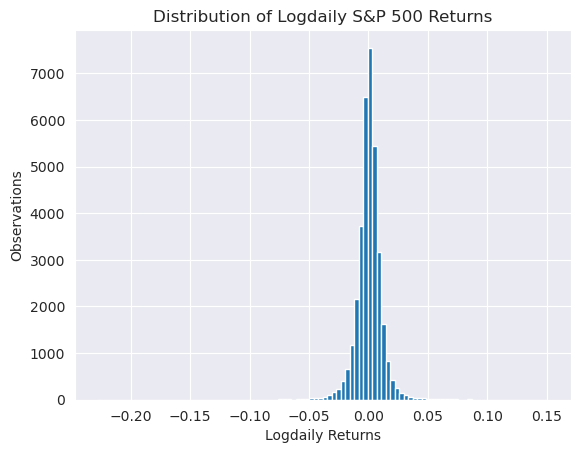

A visual inspection is far from sufficient for a test of normality. We
can first "zoom in" to the zero point to viseually cut out the outliers
of log returns of absolute magnitude $> 0.10$.

In [ ]:
log_returns.plot(kind="hist",
                          bins = 100,
                          xlabel="Log Returns",
                          ylabel="Observations",
                          xlim=(-.1,.1),
                          title="Distribution of Logdaily S&P 500 Returns")


``` example
<Axes: title={'center': 'Distribution of Logdaily S&P 500 Returns'}, xlabel='Log Returns', ylabel='Observations'>
```

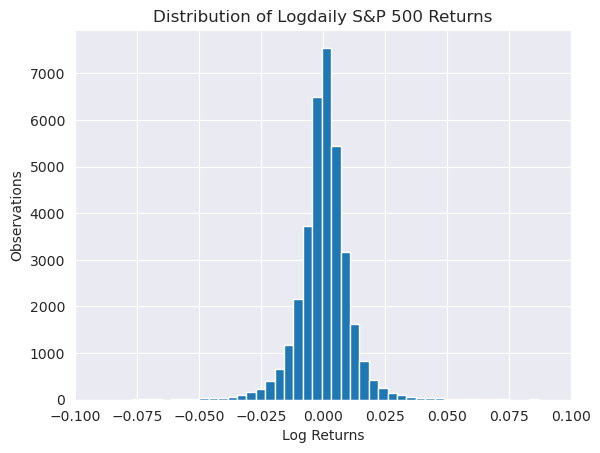

We first note that the distribution appears negatively skewed, with the
left tail being fatter than the right tail. We can verify this
empirically

In [ ]:
log_returns.skew()


``` example
np.float64(-0.43940576052749036)
```

Indeed, the distribution is negatively skewed. The value of skewness
alone gives us a hint that the data are not normally distributed.

In [ ]:
# pd.DataFrame(log_returns).boxplot()
sns.boxplot(log_returns)


``` example
<Axes: ylabel='SP500 Returns'>
```

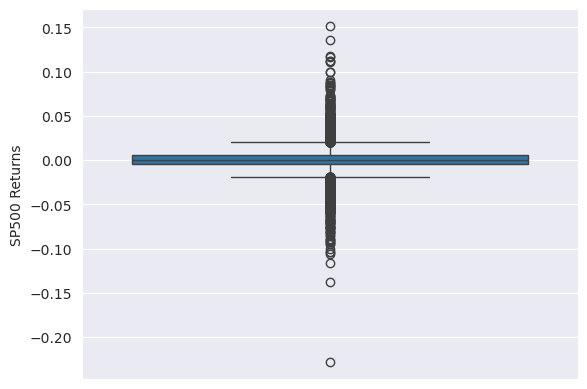

The vast majority of the log return values seem to lie in the interval
$(-0.10,0.10)$. This is the range we will inspect.

In [ ]:
clamped=pd.DataFrame(log_returns[(log_returns <= 0.1) & (log_returns >= -0.1) ])
sns.boxplot(clamped)


``` example
<Axes: >
```

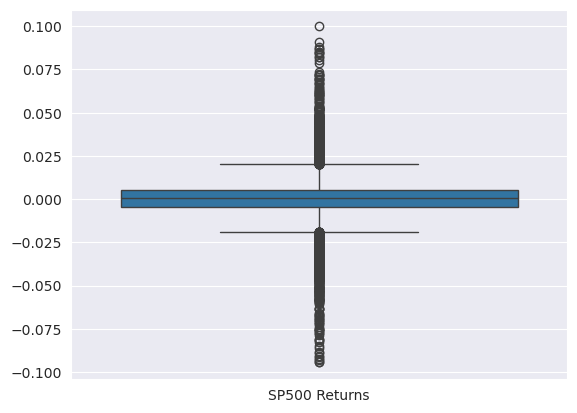

The boxplot still shows signs of negative skewness, but we can check if
the magnitude of skewness is less than what we started with.

In [ ]:
clamped.skew()


``` example
SP500 Returns   -0.330623
dtype: float64
```

The skewness does decrease in magnitude, but its value still indicates a
distribution far from normal. It seems daily returns are too negatively
skewed to recover a distribution that is normal.

Instead, we can coarsen our return periods to weekly, monthly, and
yearly returns to see if they exhibit different behaviours. We should
expect this to be an improvement on log-daily returns, since the
reliability of stock returns tends to increase the longer the time
period you look at.

In [ ]:
weekly_logs = log_returns.groupby(pd.Grouper(freq="W-MON")).agg("sum")
weekly_logs.plot(kind="hist",bins = 60,
                 title="Weekly log Returns",
                 xlabel="Log Returns")


``` example
<Axes: title={'center': 'Weekly log Returns'}, xlabel='Log Returns', ylabel='Frequency'>
```

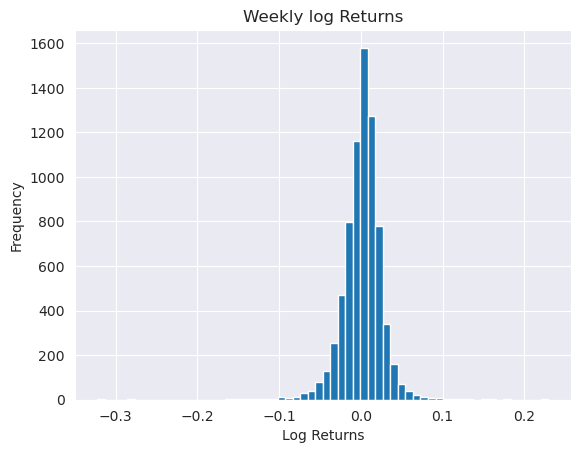

In [ ]:
weekly_logs.skew()


``` example
np.float64(-0.8428780928389739)
```

On the collection of all the data, the skewness of the weekly log
returns is less skewed than the daily log returns, but still skewed in
the same direction. We can coarsen the view to further to monthly
returns.

In [ ]:
monthly_logs = log_returns.groupby(pd.Grouper(freq="ME")).agg("sum")
monthly_logs.plot(kind="hist",bins = 60,
                 title="Monthly log Returns",
                 xlabel="Log Returns")


``` example
<Axes: title={'center': 'Monthly log Returns'}, xlabel='Log Returns', ylabel='Frequency'>
```

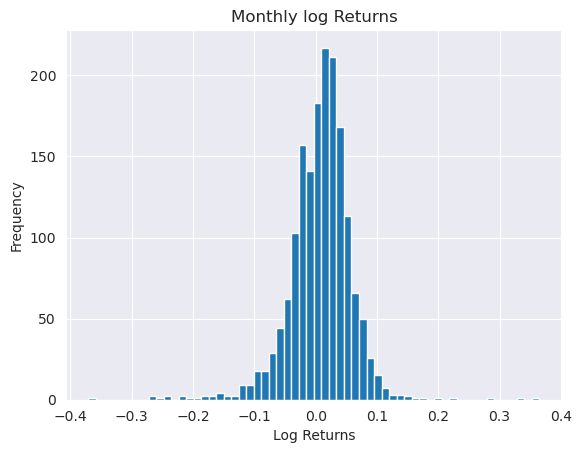

In [ ]:
monthly_logs.skew()


``` example
np.float64(-0.5649387662902664)
```

Even monthy returns are negatively skewed.

In [ ]:
yearly_logs = log_returns.groupby(pd.Grouper(freq="YE")).agg("sum")
yearly_logs.plot(kind="hist",bins = 60,
                 title="log Yearly Returns",
                 xlabel="Log Returns")


``` example
<Axes: title={'center': 'log Yearly Returns'}, xlabel='Log Returns', ylabel='Frequency'>
```

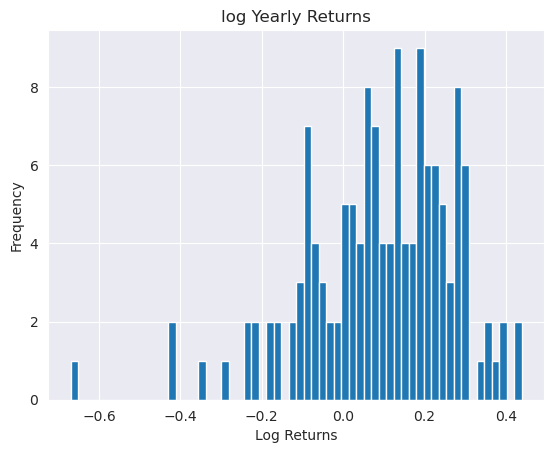

In [ ]:
yearly_logs.skew()


``` example
np.float64(-0.9182998475458627)
```

Even at time scales such as a year, returns of a diverse portfolio of US
stocks shows little evidence of being normal on visual tests.

# Formal Tests for Normality

So far, our tests for normality has been heuristic in nature. There are
formal tests for normality such as she Shapiro-Wilk test, which we can
employ. Below is the resulting $p$ values extracted from the test, where
the null hypothesis is that the data are normally distributed.

In [ ]:
from scipy.stats import shapiro
names = ["Logdaily", "Logweekly","Logmonthly","Logyearly"]
vars = [log_returns,weekly_logs,monthly_logs,yearly_logs]
results = {x[0]: float(shapiro(x[1])[1]) for x in zip(names,vars)}
print(f"Shapiro-Wilk p-values:\n {results}")


``` example
Shapiro-Wilk p-values:
 {'Logdaily': 3.818543836005726e-93, 'Logweekly': 1.178035812533499e-52, 'Logmonthly': 1.2008592564652523e-28, 'Logyearly': 0.00021204832741650683}
/nix/store/8f9zfpbmybfl09aq4a9nzp8a9gwgqjbf-python3.12-scipy-1.15.3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35112.
  res = hypotest_fun_out(*samples, **kwds)
/nix/store/8f9zfpbmybfl09aq4a9nzp8a9gwgqjbf-python3.12-scipy-1.15.3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7316.
  res = hypotest_fun_out(*samples, **kwds)
```

In every performance of the Shapiro-Wilk test, the resulting $p$ value
is decidedly below $0.05$, so in every case we reject the null
hypothesis that the data are normally distributed.

On the other hand, the `normaltest` from `scipy.stats` uses skewness and
kurtosis to compare against a normal distribtution.

In [ ]:
from scipy.stats import normaltest
print(f"p-values; skewness-kurtosis test:\n{normaltest(pd.concat([log_returns, weekly_logs, monthly_logs,yearly_logs],axis=1),nan_policy='omit',axis=0).pvalue}")


``` example
p-values; skewness-kurtosis test:
[0.00000000e+00 0.00000000e+00 2.01874396e-72 5.74204997e-06]
```

In this test, too, there is sufficient evidence to reject the hypothesis
that the data are normaly distributed at all sampled time scales.

# Testing Particular Bull Markets

Because of the pervasive observation that stock returns are negatively
skewed, we might have better luck finding evidence of normality of stock
returns during bull markets—periods where the market trends upward
without a 20% drop from its high. Bull markets are usually marked by
extended periods of lower volatility, and volatility tends to beget
volatility, causing bouts out-of-sample returns that could disrupt a
normal distribution.

We first examine the longest bull market in US history: the period
between December 1987 and March 2000

In [ ]:
start, end = ("1987-12-01","2000-03-01")
log_returns[start:end].plot(kind="hist",bins=50,xlabel="Log Daily Returns")



``` example
<Axes: xlabel='Log Daily Returns', ylabel='Frequency'>
```

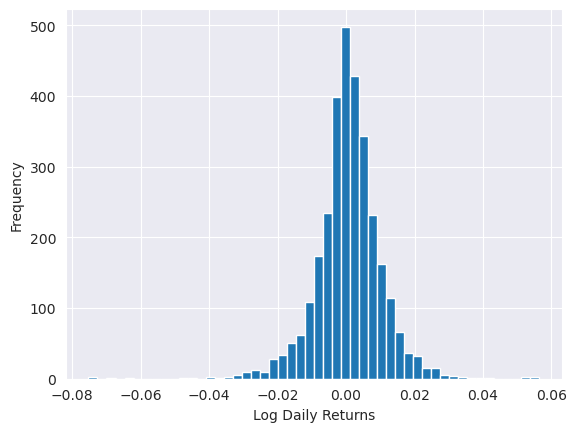

Looking at the distribution of daily returns, we can already see a
thinning of the tails, though the daily returns still appear negatively
distributed. We investigate the $p$ value of the formal Shapiro-Wilk
test on the monthly returns during this bull market.

In [ ]:
print(f"p = {shapiro(monthly_logs[start:end])[1]}")


``` example
p = 0.08925705296209206
```

With a tolerance of $p = 0.05$, there is not sufficient evidence to
reject the null hypothesis that the data is normally distributed. Thus,
there is possible evidence of the log monthly returns of the S&P 500
being normally distributed during the 1987-2000 bull market.

Let us investigate the second longest bull market spanning from March
2009 to February 2020.

In [ ]:
start, end = ("2009-03-01", "2020-02-01")
log_returns[start:end].plot(kind="hist",bins=50,xlabel="Log Daily Returns",
                            title="Log Daily Returns Mar 2009-Feb 2020")


``` example
<Axes: title={'center': 'Log Daily Returns Mar 2009-Feb 2020'}, xlabel='Log Daily Returns', ylabel='Frequency'>
```

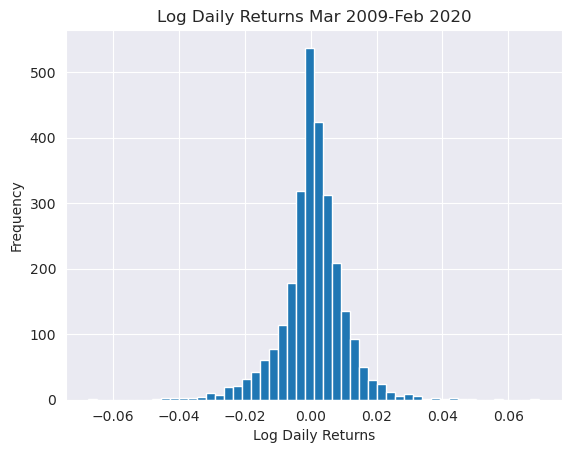

This time, the left tail is much fatter than the previous bull market
under examination.

In [ ]:
print(f"p = {shapiro(monthly_logs[start:end])[1]}")


``` example
p = 0.0011705343595598972
```

As the visual inspection suggested, we cannot conclude normality of the
monthly returns in this period.

## Conclusion

We can conclude that it is very difficult to find periods of time and
scales of time where stock returns are normally distributed, even when
volatility is controlled by using a diversified portfolio. This suggests
that the assumption of normal stock returns used in the Black-Scholes
model does not reflect reality. It still serves the useful purpose of
helping extract closed-form equation

# A "Portfolio" with Normal Return

For some commentary, we should not expect it to be easy to construct a
portfolio of stocks (i.e. **equities**) with lognormal returns over a
significant period of time. Equities are inherently riskier than other
financial assets like bonds, and show fatter tails in distributions of
historical returns on virtually all time scales. One typically reduces
the volatility of a portfolio of stocks by allocating to "safer" kinds
of stocks (e.g. consumer staples, utilities) or by moving away from
stocks altogether and using bonds. Since we are interested in stocks
only, we will work within the confines of equities.

We hypothesize that a diverse portfolio is the wrong way to mine
logreturns that might be normal. Instead, we look at a particular
individual stock in the consumer staple sector, Coca-Cola (KO).

In [ ]:
ko = csv_to_series("./KO.csv")
log_ko = np.log(1+ko["KO Returns"])


In [ ]:
shapiro(log_ko.groupby(pd.Grouper(freq="W-MON")).agg("sum"))


In [ ]:
p1 = np.log(1+ 0.20*sp500["SP500 Returns"] + 0.40*ko["KO Returns"] + 0.40*xlp["Staples Returns"])
p1[start:end].plot(kind="hist",bins=80)
shapiro(p1[start:end])


In [ ]:
np.log(ko["KO"]).plot(title="KO Logvalue: $10000 Invested",
                      ylabel = "Logvalue")


From a visual inspection of the logvalue of an investment in KO, we see
that the period between 1975 and 1982 shows promise for lognormal
returns, based on intuition alone.

In [ ]:
s1,s2 = ("1975-04-01","1982-03-01")

np.log(ko["KO"][s1:s2]).plot(title="KO Logvalue: $10000 Invested",
                      ylabel = "Logvalue")


In [ ]:
log_ko[s1:s2].plot(kind="hist",bins=80)


Apart from the distribution of logdaily returns looking more favorable
than our other assets, we can check the skewness and kurtosis:

In [ ]:
print(f"KO Skew: {log_ko[s1:s2].skew()}\nKO Kurtosis: {log_ko[s1:s2].kurtosis()}")


These metrics are the closest to normal distribution so far. A portfolio
of 100% KO might yield logreturns resembling a normal distribution from
the time period of 1975-04-01 to 1982-03-01. Over longer periods of
time, it is extremely difficult to find a stock with lognormal returns,
due to the long term observation that stocks tend to go up.

To counterbalance any indiosyncratic movement specific to the consumer
staple sector which KO operates in, we add a consumer discretionary
option to our portfolio with MCD.

In [ ]:
mcd = csv_to_series("./MCD.csv")
log_mcd = np.log(1+mcd["MCD Returns"])


In [ ]:
w1 = 0.8
w2 = 1-w1
p1 = np.log(1+ w1*ko["KO Returns"] + w2*mcd["MCD Returns"])
p1[s1:s2].plot(kind="hist",bins=80)


Even with the addition of a single stock to our portfolio at 20% weight,
our distribution gets a big hit of negative skewness, pushing it away
from normality.

# An Explanation of more diversity=less normal

As a function of diversification, negative skewness increases in
magnitude. This has an easy empirical explanation: holding more stocks
increases the reliability of consistent *positive* return, pushing the
distribution of returns away from normality. This also explains why
distributions of logreturns were less normal the more we coarsened our
time view. Generally, it is more likely for portfolio's returns to be
positive over the course of a year rather than the course of a day.

Finding normally distributed returns in stocks is essentially an
exercise in arbitrary data mining, and the pattern fails more often than
it succeeds. Though, this is the point of this exercise: the assumption
of normal stock returns in various financial models such as
Black-Scholes is not borne out in reality, and this illustrates that
plainly. The essence of assuming lognormal returns is simply a
convenience to find closed form solutions to option prices, and models
incorporating assumptions that reflect reality are much more difficult
to work with.